In [2]:
from pytfa.io.json import load_json_model
from cobra import Reaction

redgem_file_name = 'reduced_model_ETC_core_20240816-155234.json'
reduced_model = load_json_model(redgem_file_name)
reduced_model.optimize()

# remove sinks if there are still any
reduced_model.remove_reactions([rxn.id for rxn in reduced_model.reactions if 'sink' in rxn.id])

# Thermo for sodium
reduced_model.thermo_data['metabolites']['cpd00971']['deltaGf_std'] = 1.0
reduced_model.thermo_data['metabolites']['cpd00971']['deltaGf_err'] = 0.1
reduced_model.thermo_data['metabolites']['cpd00971']['error']  = 'Nil'

2024-09-16 11:00:27,536 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [3]:
# Remove constraints of type ModelConstraints 
from tqdm import tqdm

cons_subclass = reduced_model._cons_kinds['ModelConstraint']
for cons in tqdm(cons_subclass):
    reduced_model.remove_constraint(cons)

reduced_model.repair()


100%|██████████| 5/5 [00:00<00:00, 3115.66it/s]


In [4]:
# Set h_c to h_i 
h_i = reduced_model.metabolites.h_i
h_c = reduced_model.metabolites.h_c
for r in reduced_model.reactions:
    if h_i in r.metabolites:
        stoich = r.metabolites[h_i]
        r.add_metabolites({h_i: -stoich, h_c: stoich})

reduced_model.prepare()
reduced_model.convert()


2024-09-16 11:00:27,781 - thermomodel_Recon3thermoCurated - INFO - # Model preparation starting...
2024-09-16 11:00:27,792 - thermomodel_Recon3thermoCurated - INFO - # Model preparation done.
2024-09-16 11:00:27,793 - thermomodel_Recon3thermoCurated - INFO - # Model conversion starting...
2024-09-16 11:00:27,923 - thermomodel_Recon3thermoCurated - INFO - # Model conversion done.
2024-09-16 11:00:27,924 - thermomodel_Recon3thermoCurated - INFO - # Updating cobra_model variables...
2024-09-16 11:00:27,925 - thermomodel_Recon3thermoCurated - INFO - # cobra_model variables are up-to-date


In [5]:
# Refine Glycolysis corrected delta G constraints from Lehninger:
# Units are in kJ/mol
glycolysis_thermodynamics = {
    'HEX1': -16.7,
    'PGI': 1.7,
    'PFK': -14.9,
    'FBA': 23.8,
    'TPI': 5.6, # Equilibrator value
    'GAPD': 6.3,
    'PGK': -18.8,
    'PGM': 4.4, 
    'ENO': 7.5,
    'PYK': -31.4,
    'LDH_L': 25.1,
    'LDH_Lm': 33.1,
    }

# Converstion to kcal/mol
scaling = 0.239006
for r_id, dg in glycolysis_thermodynamics.items():
    dgo = reduced_model.delta_gstd.get_by_id(r_id).variable
    try:
        dgo.ub = dg * scaling + 0.1
        dgo.lb = dg * scaling - 0.1
    except ValueError:
        dgo.lb = dg * scaling - 0.1
        dgo.ub = dg * scaling + 0.1

    reduced_model.optimize()
    print(f"{r_id} : {dgo.lb} < {dgo.primal} < {dgo.ub} kcal/mol")


sol = reduced_model.optimize()

HEX1 : -4.0914002 < -4.0914002 < -3.8914001999999996 kcal/mol
PGI : 0.3063102 < 0.3063102 < 0.5063102 kcal/mol
PFK : -3.6611894 < -3.6611894 < -3.4611894 kcal/mol
FBA : 5.5883428 < 5.5883428 < 5.7883428 kcal/mol
TPI : 1.2384335999999998 < 1.292545 < 1.4384336 kcal/mol
GAPD : 1.4057377999999998 < 1.4057377999999998 < 1.6057378 kcal/mol
PGK : -4.5933128 < -4.3933128 < -4.3933128 kcal/mol
PGM : 0.9516264 < 1.1516264 < 1.1516264 kcal/mol
ENO : 1.692545 < 1.692545 < 1.8925450000000001 kcal/mol
PYK : -7.6047883999999994 < -7.6047883999999994 < -7.4047884 kcal/mol
LDH_L : 5.899050600000001 < 6.0990506 < 6.0990506 kcal/mol
LDH_Lm : 7.8110986 < 7.8110986 < 8.0110986 kcal/mol


In [6]:
# Refine TCA corrected delta G constraints from Lehninger:
# Units are in kJ/mol
tca_thermodynamics = {
    'PDHm' : -33.4,
    'CSm' : -32.3,
    'ACONTm' : 13.3,
    'ICDHxm' : 10.0, # Equilibrator value ?!?!
    'AKGDm' : -33.5,
    'SUCOAS1m' : 2.9,
    #'r0509' : 0, 
    'FUMm': -3.8,
    'MDHm' : 29.7,
    'MDH': 29.7 + 2.3 * 2 * 310 * 2.26 * (0.8) /1000 , # MDH delta proton correction in cytosol (nH 2.3 RT * delta pH)
    'ADK1': 0.3, # Equilibrator value ?!
    'FADH2ETC': -70/2, # Equilibrator  value ?
    'G3PD1': 22.6, # Equilibrator value ?!?
    'r0205': -59.7, # Equilibrator value ?!?
    'PiC': 2.3 * 310 * 2.26 * (-0.8) / 1000 ,  # Charge NEUTRAL transport of phophate -> only proton force (nH 2.3 RT * delta pH)
    'PPA': -16.5, # Equilibrator value
    'BDHm': 8.0, # Equilibrator value (EC: 1.1.1.30)
    'OCOAT1m': 12.6, # Equilibrator value (EC: 2.8.3.5)
    'ACACT1rm': 25, # Equilibrator value (EC: 2.3.1.9)
    'C160CPT1': -2.2, # Equilibrator value (EC: 2.3.1.21 reverse)
    'C160CPT1': 2.2, # Equilibrator value (EC: 2.3.1.21)
}
# Converstion to kcal/mol
scaling = 0.239006
for r_id, dg in tca_thermodynamics.items():
    dgo = reduced_model.delta_gstd.get_by_id(r_id).variable
    try:
        dgo.ub = dg * scaling + 0.1
        dgo.lb = dg * scaling - 0.1
    except ValueError:
        dgo.lb = dg * scaling - 0.1
        dgo.ub = dg * scaling + 0.1

    reduced_model.optimize()
    print(f"{r_id} : {dgo.lb} < {dgo.primal} < {dgo.ub} kcal/mol")
    

sol = reduced_model.optimize()

PDHm : -8.0828004 < -8.0828004 < -7.8828004 kcal/mol
CSm : -7.819893799999999 < -7.819893799999999 < -7.6198938 kcal/mol
ACONTm : 3.0787798 < 3.0787798 < 3.2787798 kcal/mol
ICDHxm : 2.29006 < 2.29006 < 2.49006 kcal/mol
AKGDm : -8.106701 < -8.106701 < -7.906701 kcal/mol
SUCOAS1m : 0.5931174 < 0.5931174 < 0.7931174 kcal/mol
FUMm : -1.0082228 < -1.0082228 < -0.8082228 kcal/mol
MDHm : 6.9984782 < 6.9984782 < 7.198478199999999 kcal/mol
MDH : 7.614685381248 < 7.614685381248 < 7.814685381247999 kcal/mol
ADK1 : -0.02829820000000001 < -0.02829820000000001 < 0.17170180000000002 kcal/mol
FADH2ETC : -8.465209999999999 < -8.465209999999999 < -8.26521 kcal/mol
G3PD1 : 5.3015356 < 5.3015356 < 5.5015355999999995 kcal/mol
r0205 : -14.3686582 < -14.3686582 < -14.168658200000001 kcal/mol
PiC : -0.40810359062400003 < -0.40810359062400003 < -0.208103590624 kcal/mol
PPA : -4.0435989999999995 < -4.0435989999999995 < -3.8435989999999998 kcal/mol
BDHm : 1.8120479999999999 < 1.8120479999999999 < 2.012048 kcal/m

In [7]:
# Make sure that transporters dont have unrealistic equilibrium constants
EPSILON_DG = 1e-6

exceptions = ['ATPS4mi','CYOR_u10mi','CYOOm2i','NADH2_u10mi','PiC']
# Print transport deltaG0
for r in reduced_model.reactions:
    if r.thermo['isTrans'] and (r.id not in exceptions):
        try:
            print(f"{r.id} : {r.reaction} {r.thermo['deltaGR']} kcal/mol")
            dgo = reduced_model.delta_gstd.get_by_id(r.id)
            dgo.variable.ub = r.thermo['deltaGR'] + EPSILON_DG
            dgo.variable.lb = r.thermo['deltaGR'] - EPSILON_DG
        except KeyError:
            pass

reduced_model.optimize()


AKGMALtm : akg_m + mal_L_c <=> akg_c + mal_L_m 0.0012994733051527874 kcal/mol
ASPGLUm : asp_L_m + glu_L_c + h_c --> asp_L_c + glu_L_m + h_m -5.242772133284354 kcal/mol
ATPtm : adp_c + atp_m <=> adp_m + atp_c -4.099837206092383 kcal/mol
BHBt : bhb_e + h_e <=> bhb_c + h_c 0.27246543423115455 kcal/mol
BHBtm : bhb_c + h_c <=> bhb_m + h_m -1.0902086818095462 kcal/mol
CO2tm : co2_c <=> co2_m 0.0 kcal/mol
FATP1t : hdca_c + na1_c <=> hdca_e + na1_e -1.3610152910210402 kcal/mol
GLCt1r : glc_D_e <=> glc_D_c 0.0 kcal/mol
H2Otm : h2o_c <=> h2o_m 0 kcal/mol
L_LACtm : h_c + lac_L_c <=> h_m + lac_L_m -1.0905609991066534 kcal/mol
O2tm : o2_c <=> o2_m 0.0 kcal/mol
PYRt2m : h_c + pyr_c <=> h_m + pyr_m -1.0906689378694914 kcal/mol
r2435 : crn_m + pmtcrn_c <=> crn_c + pmtcrn_m 1.3372807472933346e-05 kcal/mol
CO2t : co2_e <=> co2_c 0.0 kcal/mol
H2Ot : h2o_e <=> h2o_c 0 kcal/mol
L_LACt2r : h_e + lac_L_e <=> h_c + lac_L_c 0.27261990058316243 kcal/mol
NAt3_1 : h_e + na1_c <=> h_c + na1_e -1.0890464745750492 k

,fluxes,reduced_costs
ACACT1rm,-1.000000,None
ACONTm,12.861111,None
AKGDm,12.861111,None
AKGMALtm,0.000000,None
ASPGLUm,0.000000,None
...,...,...
CYOR_u10mi,72.166667,None
NADH2_u10mi,52.305556,None
CYOOm2i,36.083333,None
cyt_atp2adp,172.416667,None


In [8]:
import numpy as np
from pytfa.optim.constraints import ModelConstraint

# Force ATP/ADP ratio to be 10
# Cytosolic ATP/ADP ratio
# https://pubmed.ncbi.nlm.nih.gov/749453/



expression = reduced_model.log_concentration.atp_c.variable - reduced_model.log_concentration.adp_c.variable
id_='atp_c_adp_c_ratio'

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_=id_, 
                        lb=np.log(10), 
                        ub=np.log(500),
                        )
print(f"Integrate cytosolic ATP/ADP ratio: 10-50 ")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")


# Force ATP/ADP ratio to bearround 2 and 8
# Cytosolic ATP/ADP ratio
# https://www.mdpi.com/1422-0067/23/10/5550


expression = reduced_model.log_concentration.atp_m.variable - reduced_model.log_concentration.adp_m.variable
id_='atp_m_adp_m_ratio'

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_=id_, 
                        lb=np.log(2), 
                        ub=np.log(8),
                        )
print(f"Integrate mitochondrial ATP/ADP ratio: 2-8")
sol = reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")

# mitochondrial GTP/GDP ratio
expression = reduced_model.log_concentration.gtp_m.variable - reduced_model.log_concentration.gdp_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='gtp_m_gdp_m_ratio', 
                        lb=np.log(10), 
                        ub=np.log(300),
                        )
print(f"Integrate mitochondrial GTP/GDP ratio: 10-300")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")        

# # mitochondrial NAD/NADH ratio
# expression = reduced_model.log_concentration.nad_m.variable - reduced_model.log_concentration.nadh_m.variable
reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='nad_m_nadh_m_ratio', 
                        lb=np.log(0.1), 
                        ub=np.log(10),
                        )
print(f"Integrate mitochondrial NAD+/NADH ratio: 0.1-10")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")  

# Cytoplasmic NAD/NADH ratio
expression = reduced_model.log_concentration.nad_c.variable - reduced_model.log_concentration.nadh_c.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='nad_c_nadh_c_ratio', 
                        lb=np.log(1), 
                        ub=np.log(500),
                        )

print(f"Integrate cytoplasmic NAD+/NADH ratio: 1-500")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")  

Integrate cytosolic ATP/ADP ratio: 10-50 
ATP yield: 172.4166666666666
Integrate mitochondrial ATP/ADP ratio: 2-8
ATP yield: 172.4166666666666
Integrate mitochondrial GTP/GDP ratio: 10-300
ATP yield: 172.41666666666669
Integrate mitochondrial NAD+/NADH ratio: 0.1-10
ATP yield: 172.41666666666669
Integrate cytoplasmic NAD+/NADH ratio: 1-500
ATP yield: 172.41666666666669


In [9]:
# Flux constraints for the core model 
RER = 0.79
fraction_of_whole_body_o2 = 0.8
total_carbon_contribution_modeled = 0.8

o2_uptake = 2.0 * fraction_of_whole_body_o2 * total_carbon_contribution_modeled
co2_production = o2_uptake * RER 

# oxygen uptake about of redmuscle 80% of total oxygen uptake 2000 nmol/min/gBW -2 umol/min/gDW
reduced_model.reactions.EX_o2_e.bounds = (-o2_uptake, -o2_uptake)
# Constrain the RET to about 0.8 of the total glucose uptake
#reduced_model.reactions.EX_co2_e.bounds = (co2_production, co2_production)
#reduced_model.reactions.CO2tm.bounds = (-10, -co2_production*0.5)

#Dont waste ATP by cycling via ACYP
reduced_model.reactions.ACYP.bounds = (0,0)

# MDHm is forward driven 
reduced_model.reactions.MDHm.bounds = (0.1, 100)

reduced_model.optimize()


#Add constraints for CO2 production in the core model of and glucose, lactate
glucose_direct_contribution = 0.042 / 6 / total_carbon_contribution_modeled
lactate_direct_contribution = 0.24 / 3 / total_carbon_contribution_modeled
bhb_direct_contribution = 0.021 / 4 / total_carbon_contribution_modeled 


reduced_model.reactions.EX_glc_D_e.bounds = (-co2_production * glucose_direct_contribution, -co2_production * glucose_direct_contribution)
reduced_model.reactions.EX_lac_L_e.bounds = (-co2_production * lactate_direct_contribution, -co2_production * lactate_direct_contribution)
reduced_model.reactions.EX_bhb_e.bounds = (-co2_production * bhb_direct_contribution, -co2_production * bhb_direct_contribution)

sol = reduced_model.optimize()


In [10]:
# Function to integrate metabolite concentrations
import numpy as np 
from optlang.exceptions import SolverError

def set_concentration(model, metabolite_id, concentration, uncertainty=0.1, unit='mmol/L', std=None):
    if unit == 'mmol/L':
        concentration = concentration / 1000

        if not np.isscalar(uncertainty):
            uncertainty = [x/1000 for x in uncertainty]
            
        if not std is None:
            std = std/1000

    else:
        raise ValueError('Unit not supported')
    

    metabolite = model.log_concentration.get_by_id(metabolite_id)
    compartment = model.metabolites.get_by_id(metabolite_id).compartment
    c_min = reduced_model.compartments[compartment]['c_min']

    var = metabolite.variable

    if (std is None) and np.isscalar(uncertainty):
        try:            
            var.ub = np.log(concentration + concentration * uncertainty)
            var.lb = np.log(concentration - concentration * uncertainty)
        except ValueError:
            var.lb = np.log(concentration - concentration * uncertainty)
            var.ub = np.log(concentration + concentration * uncertainty)
    elif (std is None) and (len(uncertainty) == 2):
        try:
            var.lb = np.log(uncertainty[0])
            var.ub = np.log(uncertainty[1])
        except ValueError:
            var.ub = np.log(uncertainty[1])
            var.lb = np.log(uncertainty[0])
            
    elif std is not None:
        try:
            var.ub = np.log(concentration + std)
            lb = np.log(concentration - std) if concentration - std > c_min else np.log(c_min)
            var.lb = lb
        except ValueError:
            lb = np.log(concentration - std) if concentration - std > c_min else np.log(c_min)
            var.lb = lb
            var.ub = np.log(concentration + std)
    else:
        raise ValueError('Uncertainty not supported')
        
    # Test the constraint
    try:
        sol = model.optimize()
        if sol.status != 'optimal':
            raise ValueError(f'Constraining {metabolite_id} to {concentration} failed.')
    except:
        raise ValueError(f'Constraning {metabolite_id} to {concentration} failed.')
    

In [11]:
# Integrate serum metabolomics 

# Glucose concentration in serum
glucose_concentration = 5.5 # mmol/L 
# Lactate concentration in serum
lactate_concentration = 0.75 # mmol/L
# Fatty-acid concentration in serum
fatty_acid_concentration = 0.5 # mmol/L
# Ketone concentration in serum 
ketone_concentration = 0.1 # mmol/L

# O2 concentration in serum 80 mmHG -> to mmol/L
T = 273.15 + 37
o2_concentration_artery = 1e3 * 80/ (62.36367*T)
o2_concentration_muscle = 1e3 * 30/ (62.36367*T)

# CO2 concentration in serum 40 mmHG -> to mmol/L
co2_concentration = 1e3 * 40/ (62.36367*T)

na1_concentration_serum = 140 # mmol/L
na1_concentration_muscle = 20 # mmol/L

set_concentration(reduced_model, 'glc_D_e', glucose_concentration)

set_concentration(reduced_model, 'lac_L_e', lactate_concentration)



set_concentration(reduced_model, 'hdca_e', fatty_acid_concentration)
set_concentration(reduced_model, 'bhb_e', fatty_acid_concentration)
set_concentration(reduced_model, 'o2_e', o2_concentration_artery, uncertainty=0.1)
set_concentration(reduced_model, 'o2_c', o2_concentration_muscle*0.75, uncertainty=0.1)
set_concentration(reduced_model, 'o2_m', o2_concentration_muscle*0.5, uncertainty=0.1)

set_concentration(reduced_model, 'co2_e', co2_concentration)

# Not in new model...
set_concentration(reduced_model, 'na1_e', na1_concentration_serum)
set_concentration(reduced_model, 'na1_c', na1_concentration_muscle)


# Set the concentration of the cytosol -> 10% of the serum concentration
set_concentration(reduced_model, 'hdca_c', fatty_acid_concentration*0.1)

reduced_model.optimize()


,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442937,None
AKGDm,0.442937,None
AKGMALtm,0.000000,None
ASPGLUm,0.000000,None
...,...,...
CYOR_u10mi,2.560000,None
NADH2_u10mi,1.845071,None
CYOOm2i,1.280000,None
cyt_atp2adp,6.061355,None


In [12]:
# Run a flux analysis to see how constrain is the flux 
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')

# Plot the fluxes as bars starting at min and ending at max
FVA['range'] = FVA.maximum - FVA.minimum
FVA['mid'] = (FVA.maximum + FVA.minimum) / 2

fasted_fluxes = FVA['mid']

2024-09-16 11:00:28,374 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 71/71 [00:00<00:00, 402.14it/s]


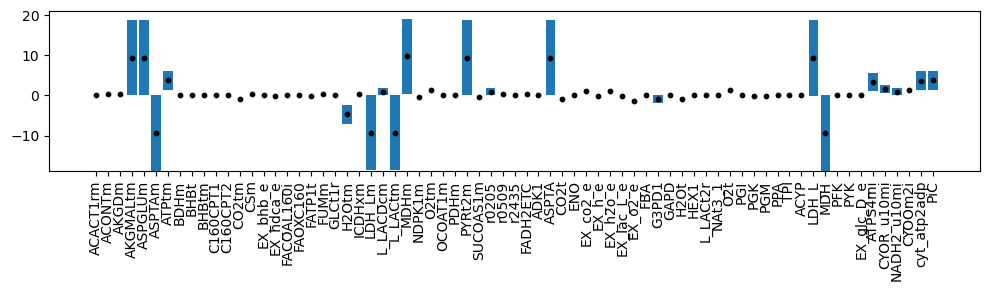

In [13]:
# Plot the flux variablity analysis
import matplotlib.pyplot as plt
import seaborn as sns

f = plt.figure(figsize=(10, 3))
plt.bar(FVA.index, FVA.range, bottom=FVA.minimum)
plt.scatter(FVA.index, FVA.mid, color='k', s=10)

# from cobra.flux_analysis.parsimonious import optimize_minimal_flux
# reduced_model.objective = reduced_model.problem.Objective(reduced_model.reactions.cyt_atp2adp.forward_variable, direction='max')
# sol = optimize_minimal_flux(reduced_model)
# plt.scatter(sol.fluxes.index, sol.fluxes, color='r', s=10)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [14]:
EPSILON = 1e-6

bidir = []
# Print bidreactional reactions from FVA
for r in reduced_model.reactions:
    if FVA.loc[r.id, 'minimum'] < -EPSILON and FVA.loc[r.id, 'maximum'] > EPSILON:
        print(r.id, r.reaction, FVA.loc[r.id, ['minimum', 'maximum']].values)
        bidir.append(r.id)


LDH_Lm lac_L_m + nad_m <=> 2.0 h_m + nadh_m + pyr_m [-18.62146678   0.118816  ]
L_LACtm h_c + lac_L_c <=> h_m + lac_L_m [-18.62146678   0.118816  ]
LDH_L lac_L_c + nad_c <=> 2.0 h_c + nadh_c + pyr_c [-1.76960000e-02  1.87225868e+01]


In [15]:
reduced_model.optimize()

,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442937,None
AKGDm,0.442937,None
AKGMALtm,0.000000,None
ASPGLUm,0.000000,None
...,...,...
CYOR_u10mi,2.560000,None
NADH2_u10mi,1.845071,None
CYOOm2i,1.280000,None
cyt_atp2adp,6.061355,None


In [16]:
# Limit lactate and pyruvate concentration to be << one order of magnitude of the LDH and PDH KM
# LDH
ldh_km = 10 # mmol/L
set_concentration(reduced_model, 'lac_L_c', ldh_km, uncertainty=[0.1, 100]) # Two orders of magnitude less than the KM of LDH
set_concentration(reduced_model, 'lac_L_m', ldh_km, uncertainty=[0.1, 100]) # Two orders of magnitude less than the KM of LDH

# PDH m 
pdh_km = 0.1 # mmol/L
set_concentration(reduced_model, 'pyr_c', pdh_km, uncertainty=[0.001,1.0]) # One order of magnitude less than the KM of LDH
set_concentration(reduced_model, 'pyr_m', pdh_km, uncertainty=[0.001,1.0]) # One order of magnitude less than the KM of LDH



In [17]:
# Sample the model
from pytfa.analysis import  apply_reaction_variability,     \
                            apply_generic_variability,      \
                            apply_directionality

from pytfa.optim.variables import DeltaG,DeltaGstd,LogConcentration
from pytfa.optim import strip_from_integer_variables
from pytfa.analysis import sample

def convert_and_sample_the_model(model, n_samples=1000, bidir=[]):

    # Fesiblitity analysis
    solution = model.optimize()

    # Print solution of the bidreactional reactions
    for r in bidir:
        print(r, solution[r])

    # TVA of the model
    thermo_vars = [DeltaG,DeltaGstd,LogConcentration]
    TVA = variability_analysis(model, kind=thermo_vars)

    # Strip model of integers variables
    fixed_directionality_model = apply_directionality(model, solution)
    tight_model = apply_reaction_variability(fixed_directionality_model, FVA)
    tight_model = apply_generic_variability (tight_model  , TVA)

    continuous_model = strip_from_integer_variables(tight_model)
    continuous_model.repair()

    continuous_model.solver.configuration.tolerances.feasibility = 1e-9
    continuous_model.solver.configuration.tolerances.optimality = 1e-9
    continuous_model.solver.configuration.tolerances.integrality = 1e-9

    # Sample the concnetrations and fluxes in the continuous_model
    sampling = sample(continuous_model, n_samples, processes=4, seed=0,  method='optgp')

    return sampling
        

In [18]:
# Flux directionalty profile 1 (Exhaust vent model)

reduced_model_copy = reduced_model.copy()
# Set the direction of the LDH reaction to produce pyruvate
reduced_model_copy.reactions.LDH_L.bounds = (0.01, 0.5)
# Set the direction of the LDHm reaction to produce lactate
reduced_model_copy.reactions.LDH_Lm.bounds = (-0.5, -0.01)

sampling_fdp1 = convert_and_sample_the_model(reduced_model_copy, n_samples=5000, bidir=bidir)


2024-09-16 11:00:29,832 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-16 11:00:30,034 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>


LDH_Lm -0.01
L_LACtm -0.01
LDH_L 0.11112000000000002


maximizing: 100%|██████████| 61/61 [00:00<00:00, 77.60it/s]
2024-09-16 11:00:31,794 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaGstd'>
maximizing: 100%|██████████| 61/61 [00:00<00:00, 86.52it/s] 
2024-09-16 11:00:32,663 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 83/83 [00:00<00:00, 96.94it/s] 
2024-09-16 11:00:34,050 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


Is the cobra_model still integer ? False


2024-09-16 11:00:34,416 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-16 11:00:34,927 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-16 11:00:35,356 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm
2024-09-16 11:00:35,356 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm_reverse_3c90a
2024-09-16 11:00:35,357 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm
2024-09-16 11:00:35,357 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm_reverse_8079b
2024-09-16 11:00:35,358 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm
2024-09-16 11:00:35,358 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm_reverse_ec8eb


In [19]:
# Flux directionalty profile 2 (Lactate shuttle)
reduced_model_copy = reduced_model.copy()
# Set the direction of the LDH reaction to produce lactate
reduced_model_copy.reactions.LDH_L.bounds = (-0.5, -0.01)
# Set the direction of the LDHm reaction to produce pyruvate
reduced_model_copy.reactions.LDH_Lm.bounds = (0.01, 0.5)

sampling_fdp2 = convert_and_sample_the_model(reduced_model_copy, n_samples=5000, bidir=bidir)

2024-09-16 11:00:47,301 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-16 11:00:47,506 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>


LDH_Lm 0.11881600000000003
L_LACtm 0.11881600000000003
LDH_L -0.017696000000000003


maximizing: 100%|██████████| 61/61 [00:00<00:00, 81.93it/s] 
2024-09-16 11:00:49,224 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaGstd'>
maximizing: 100%|██████████| 61/61 [00:00<00:00, 187.94it/s]
2024-09-16 11:00:49,686 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 83/83 [00:00<00:00, 235.58it/s]
2024-09-16 11:00:50,520 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


Is the cobra_model still integer ? False


2024-09-16 11:00:50,978 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-16 11:00:51,468 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-16 11:00:51,906 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm
2024-09-16 11:00:51,907 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm_reverse_3c90a
2024-09-16 11:00:51,907 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm
2024-09-16 11:00:51,908 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm_reverse_8079b
2024-09-16 11:00:51,908 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm
2024-09-16 11:00:51,909 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm_reverse_ec8eb


In [20]:
# Flux directionalty profile 3 (Dual use of lactate)

reduced_model_copy = reduced_model.copy()
# Set the direction of the LDH reaction to produce pyruvate
reduced_model_copy.reactions.LDH_L.bounds = (0.01, 0.05)
# Set the direction of the LDHm reaction to produce pyruvate
reduced_model_copy.reactions.LDH_Lm.bounds = (0.01, 0.05)

sampling_fdp3 = convert_and_sample_the_model(reduced_model_copy, n_samples=5000)

2024-09-16 11:01:03,912 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-16 11:01:04,113 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 61/61 [00:00<00:00, 94.12it/s]
2024-09-16 11:01:05,531 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaGstd'>
maximizing: 100%|██████████| 61/61 [00:00<00:00, 98.40it/s] 
2024-09-16 11:01:06,319 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 83/83 [00:00<00:00, 119.54it/s]
2024-09-16 11:01:07,455 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


Is the cobra_model still integer ? False


2024-09-16 11:01:07,841 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-16 11:01:08,329 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2024-09-16 11:01:08,737 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm
2024-09-16 11:01:08,738 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm_reverse_3c90a
2024-09-16 11:01:08,738 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm
2024-09-16 11:01:08,739 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm_reverse_8079b
2024-09-16 11:01:08,739 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm
2024-09-16 11:01:08,740 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm_reverse_ec8eb


In [21]:
def transform_and_compute_redox_ratios(sampling):
    # Transform the log concentration to concentration
    for var in sampling.columns:
        if var.startswith('LC_'):
            sampling[var] = np.exp(sampling[var])
    # Compute nad/nadh ratio in cytosol and mitochondria
    sampling['nadh_nad_c'] = sampling['LC_nadh_c'] / sampling['LC_nad_c']
    sampling['nadh_nad_m'] = sampling['LC_nadh_m'] / sampling['LC_nad_m']
    # Compute atp/adp ratio in cytosol and mitochondria
    sampling['atp_adp_c'] = sampling['LC_atp_c'] / sampling['LC_adp_c']
    sampling['atp_adp_m'] = sampling['LC_atp_m'] / sampling['LC_adp_m']
    # Compute pyr/lac ratio in cytosol and mitochondria
    sampling['pyr_lac_c'] = sampling['LC_pyr_c'] / sampling['LC_lac_L_c']
    sampling['pyr_lac_m'] = sampling['LC_pyr_m'] / sampling['LC_lac_L_m']
    # Compute aspartate/glutaamate ratio in cytosol and mitochondria
    sampling['asp_glu_c'] = sampling['LC_asp_L_c'] / sampling['LC_glu_L_c']
    sampling['asp_glu_m'] = sampling['LC_asp_L_m'] / sampling['LC_glu_L_m']
    # Compute alpha-ketoglutarate/malate ratio in cytosol and mitochondria
    sampling['akg_mal_c'] = sampling['LC_akg_c'] / sampling['LC_mal_L_c']
    sampling['akg_mal_m'] = sampling['LC_akg_m'] / sampling['LC_mal_L_m']

    

In [22]:
transform_and_compute_redox_ratios(sampling_fdp1)
transform_and_compute_redox_ratios(sampling_fdp2)
transform_and_compute_redox_ratios(sampling_fdp3)

In [23]:
# Combine the data sets 
sampling_fdp1['fdp'] = 'Exhaust vent'
sampling_fdp2['fdp'] = 'Lactate shuttle'
sampling_fdp3['fdp'] = 'Dual oxidation lactate'

In [24]:
import pandas as pd
# Concatenate the data sets
sampling = pd.concat([sampling_fdp1, sampling_fdp2, ])

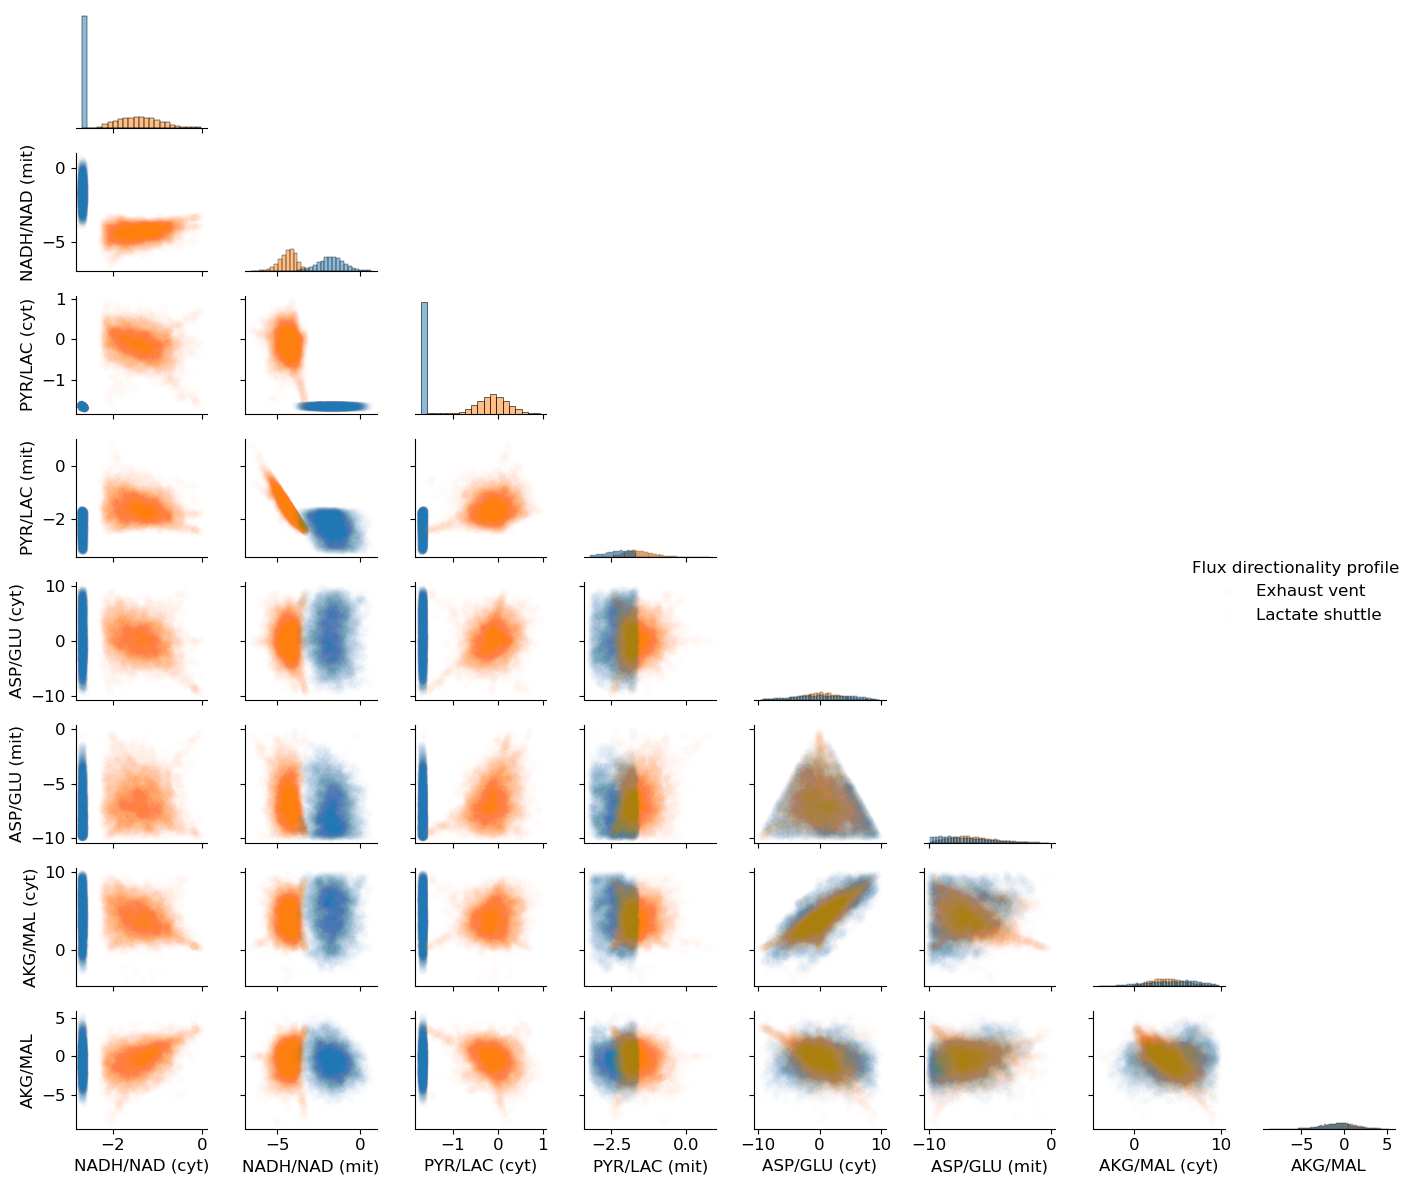

In [25]:
# Filter valitables 
vars = [ 'nadh_nad_c', 'nadh_nad_m', 'pyr_lac_c', 'pyr_lac_m', 'asp_glu_c', 'asp_glu_m', 'akg_mal_c', 'akg_mal_m']
import seaborn as sns
# Set font 
plt.rcParams.update({'font.size': 12})

# Make a pairplot of the redox ratios
data = np.log10(sampling[vars] ) 
data['fdp'] = sampling['fdp']

# Change column names to something short and readable
#data.columns = ['NADH/NAD (cyt)', 'Pyruvate (cyt)', 'Lactate (cyt)', 'NADH/NAD (mit)', 'Lactate (mit)', 'Pyruvate (mit)', 'Flux directionality profile']
# Electron donor/acceptor ratios
data.columns = ['NADH/NAD (cyt)', 'NADH/NAD (mit)', 'PYR/LAC (cyt)', 'PYR/LAC (mit)', 'ASP/GLU (cyt)', 
                'ASP/GLU (mit)', 'AKG/MAL (cyt)', 'AKG/MAL', 'Flux directionality profile']

sns.pairplot(data, hue='Flux directionality profile', corner=True, diag_kind="hist", plot_kws={'alpha':0.01,'sizes':0.1}, height=1.5)
plt.tight_layout()
plt.show()